In [45]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from datetime import datetime
from keystroke_module import *

In [46]:
class nqDataset:
    def __init__(self, filename1, filename2):

        # load data
        df1 = pd.read_csv(filename1)
        df2 = pd.read_csv(filename2)
        df_conc = pd.concat([df1, df2], ignore_index=True)
        df_conc.rename(columns={"updrs108": "updrs",
                       "gt": "Parkinsons"}, inplace=True)
        df_conc.drop('nqScore', axis=1, inplace=True)
        df_conc['Parkinsons'] = df_conc['Parkinsons'].map(
            {True: 1.0, False: 0.0})

        self.user_info = df_conc

        # split for train and test
        self.train_df, self.test_df = train_test_split(
            self.user_info, test_size=0.3, random_state=42)

        self.train_ground_truth = self.train_df['Parkinsons'].to_numpy()
        self.test_ground_truth = self.test_df['Parkinsons'].to_numpy()
        self.trainset = None
        self.testset = None

    def show_stats(self):
        print('Patients with PD: ', len(
            self.user_info[self.user_info['Parkinsons'] == False]))
        print('Patients without PD: ', len(
            self.user_info[self.user_info['Parkinsons'] == True]))
        plt.figure(figsize=[4, 3])
        sns.countplot(x='Parkinsons', data=self.user_info)
        plt.xlabel('Parkinson\'s disease')

    @staticmethod
    def load_record(filename):
        df = pd.read_csv(filename, header=None, names=[
            'pressedKey', 'holdTime', 'releaseTime', 'pressTime'])
        df['flightTime'] = df['pressTime'] - \
            pd.concat([pd.Series(0), df['releaseTime']], ignore_index=True)
        df['latencyTime'] = df['flightTime'] + \
            pd.concat([pd.Series(0), df['holdTime']], ignore_index=True)

        return df

    def prepare_dataset(self, path, feature_extract=2):

        if feature_extract == 2:
            self.trainset = np.zeros([len(self.train_df), 22])

        for i, row in self.train_df.reset_index(inplace=False).iterrows():
            # DO NOT iterate: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
            # use .apply() instead

            print(i)
            df_ID = self.load_record(path + row['file_1'])
            df_ID = filter_record(df_ID, key_filter=True)

            if feature_extract == 2:
                va_HT = feature_extract_method_2(
                    df_ID, dynamic_feature='holdTime', time_feature='releaseTime', assumed_length=360, window_time=20)
                va_NFT = feature_extract_method_2(
                    df_ID, dynamic_feature='flightTime',  time_feature='releaseTime', assumed_length=360, window_time=20, normalize_option=True)
                self.trainset[i, :] = np.concatenate([va_HT, va_NFT], axis=0)

Patients with PD:  43
Patients without PD:  42


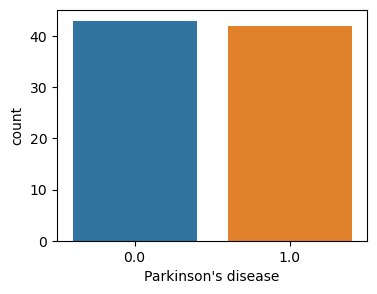

In [47]:
filename1 = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS1PD/GT_DataPD_MIT-CS1PD.csv'
filename2 = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS2PD/GT_DataPD_MIT-CS2PD.csv'
path = 'D:/studia_mgrEIM/master_diploma/data/neuroqwerty/all/'

data1 = nqDataset(filename1, filename2)
data1.show_stats()

In [49]:
data1.prepare_dataset(path, feature_extract=2)
print(data1.trainset.shape)

0


KeyboardInterrupt: 

In [ ]:
data1.train_ground_truth

array([1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 1.])

## Read data - (1. dataset)

In [81]:
# load Ground Truth
df1 = pd.read_csv('D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS1PD/GT_DataPD_MIT-CS1PD.csv')
df1.rename(columns={"updrs108": "updrs"}, inplace=True)
df1.drop('nqScore', axis=1, inplace=True)
df1.head()

,pID,gt,updrs,afTap,sTap,typingSpeed,file_1,file_2
0,11,True,14.25,NaN,162.25,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv
1,60,False,2.00,NaN,162.25,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv
2,67,True,25.25,NaN,133.75,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv
3,68,False,6.00,NaN,159.00,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv
4,70,True,26.25,NaN,113.50,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv


In [ ]:
df1.shape

(31, 8)

In [ ]:
print('Patients with PD: ', len(df1[df1['gt']==False]))
print('Patients without PD: ', len(df1[df1['gt']==True]))

Patients with PD:  13
Patients without PD:  18


In [82]:
# load Ground Truth
df2 = pd.read_csv('D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS2PD/GT_DataPD_MIT-CS2PD.csv')
df2.rename(columns={"updrs108": "updrs"}, inplace=True)
df2.drop('nqScore', axis=1, inplace=True)
df2.head()

,pID,gt,updrs,afTap,sTap,typingSpeed,file_1
0,1000,True,27,79.0,184.5,56.866667,1424946827.1000_001_014.csv
1,1001,True,16,96.5,189.0,118.000000,1427279751.1001_001_014.csv
2,1002,False,5,140.0,158.0,119.037037,1426676689.1002_001_014.csv
3,1004,True,22,83.5,191.5,74.266667,1429866367.1004_001_014.csv
4,1005,True,17,68.0,150.0,74.969697,1430134526.1005_001_014.csv


In [ ]:
print('Patients with PD: ', len(df2[df2['gt']==False]))
print('Patients without PD: ', len(df2[df2['gt']==True]))

Patients with PD:  30
Patients without PD:  24


In [83]:
df_conc = pd.concat([df1, df2], ignore_index=True)
df_conc.tail()

,pID,gt,updrs,afTap,sTap,typingSpeed,file_1,file_2
80,1063,False,0.0,110.0,170.0,109.800000,1463511198.1063_001_014.csv,NaN
81,1064,True,28.0,75.5,140.0,105.333333,1458723488.1064_001_014.csv,NaN
82,1066,True,12.0,118.0,170.5,140.250000,1460104760.1066_001_014.csv,NaN
83,1068,True,26.0,65.5,98.0,48.800000,1460559248.1068_001_014.csv,NaN
84,1070,False,2.0,126.0,154.5,54.933333,1463130212.1070_001_014.csv,NaN


Text(0.5, 0, 'Parkinson disease')

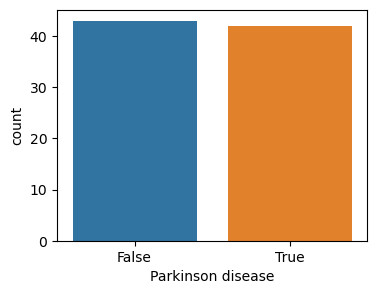

In [ ]:
plt.figure(figsize=[4,3])
sns.countplot(x = 'gt', data = df_conc)
plt.xlabel('Parkinson disease')

In [84]:
# read example file
df_ID = pd.read_csv('D:/studia_mgrEIM/master_diploma/data/neuroqwerty/MIT-CS2PD/data_MIT-CS2PD/'+ df2['file_1'][1], header = None, names=['pressedKey','holdTime', 'releaseTime', 'pressTime'])
df_ID.head()

,pressedKey,holdTime,releaseTime,pressTime
0,2,0.1135,1.4512,1.3377
1,parenright,0.1269,2.3214,2.1945
2,Shift_L,0.2064,2.3555,2.1491
3,space,0.1317,3.2163,3.0847
4,mouse_left,0.1001,6.7385,6.6384


In [89]:
len(df_ID['flightTime'])

1749

In [88]:
df_ID['flightTime'] = df_ID['pressTime'] - \
    pd.concat([pd.Series(0), df_ID['releaseTime']], ignore_index=True)
df_ID.tail()

,pressedKey,holdTime,releaseTime,pressTime,flightTime
1744,Shift_L,0.3029,771.9147,771.6118,-0.2687
1745,Return,0.0978,774.1936,774.0958,2.1811
1746,minus,0.0979,774.5318,774.4340,0.2404
1747,space,0.1241,775.0568,774.9327,0.4009
1748,Shift_L,0.6236,778.9472,778.3236,3.2668


In [92]:
df_ID['latencyTime']=df_ID['flightTime']+pd.concat([pd.Series(0),df_ID['holdTime']],ignore_index=True)
df_ID.tail()

,pressedKey,holdTime,releaseTime,pressTime,flightTime,latencyTime
1744,Shift_L,0.3029,771.9147,771.6118,-0.2687,-0.1766
1745,Return,0.0978,774.1936,774.0958,2.1811,2.4840
1746,minus,0.0979,774.5318,774.4340,0.2404,0.3382
1747,space,0.1241,775.0568,774.9327,0.4009,0.4988
1748,Shift_L,0.6236,778.9472,778.3236,3.2668,3.3909


In [ ]:
# len(df_ID[df_ID['holdTime']>1])/len(df_ID)
len(df_ID[df_ID['holdTime']>5])

33

### Filtering  (1. dataset)

In [ ]:
# basic filters
print(df_ID.shape)
df_ID_new = df_ID.drop(df_ID[df_ID['holdTime']>5].index)
print(df_ID_new.shape)
df_ID_new.drop(df_ID_new[df_ID_new['holdTime']<0].index, inplace=True)
print(df_ID_new.shape)
df_ID_new.drop(df_ID_new[df_ID_new['releaseTime']<0].index, inplace=True)
print(df_ID_new.shape)

(1749, 6)
(1716, 6)
(1716, 6)
(1716, 6)


In [ ]:
# filters for 1. dataset

pattern = 'mouse|BackSpace|Shift|Alt|Control|Num_Lock|Return|P_Enter|Caps_Lock|Left|Right|Up|Down'
pattern += '|more|less|exclamdown|\[65027\]|\[65105\]|ntilde|minus|equal|bracket|semicolon|slash|apostrophe|grave|question|right|left'

# re.compile()
# spację zostawiamy, comma i period takze
len(df_ID_new[df_ID_new['pressedKey'].str.contains(pattern, regex=True)])/1750
# jak dużo danych tracimy w wyniku filtracji? ~10%

df_ID_new = df_ID_new[~df_ID_new['pressedKey'].str.contains(pattern, regex=True)]
print(df_ID_new.shape)

(1573, 6)


In [ ]:
# import nqDataLoader as nq
# pressedKey, holdTime, pressTime, releaseTime= nq.getDataFiltHelper(fileIn)

### Feature extraction - 1. approach  (1. dataset)

In [ ]:
# https://www.nature.com/articles/srep34468

# to będzie potem w zapętleniu x razy, x - liczba blokow Bi
df_newtemp = df_ID[df_ID['releaseTime'] < 90]  # zakładana długość
Q1 = df_newtemp['holdTime'].quantile(q=0.25)
Q3 = df_newtemp['holdTime'].quantile(q=0.75)
IQR = Q3 - Q1
upper_lim = Q3 + 1.5*IQR
lower_lim = Q1 - 1.5*IQR
vout = len(df_newtemp[(df_newtemp['holdTime'] < lower_lim)
           | (df_newtemp['holdTime'] > upper_lim)])
viqr = (df_newtemp['holdTime'].quantile(q=0.5 - Q1))/(Q3 - Q1)
hist, bin_edges = np.histogram(df_newtemp['holdTime'], bins=4, density=True)
vhist1, vhist2, vhist3, vhist4 = hist * np.diff(bin_edges)
# vde - dla wszystkich i potem dodac czy jak?

### Feature extraction - 2. approach  (1. dataset)

7
0.11932857142857144
19
0.11850526315789472
24
0.11509166666666666
43
0.11420000000000001
44
0.1181181818181818
47
0.1245851063829787
54
0.1181314814814815
46
0.1117717391304348
41
0.10615121951219512
43
0.11436511627906977
55
0.1078509090909091
52
0.11059230769230771
55
0.11260181818181822
49
0.16230816326530612
56
0.2390196428571429
37
0.15952702702702704
36
0.2908055555555555
47
0.11350425531914891
(18, 18)


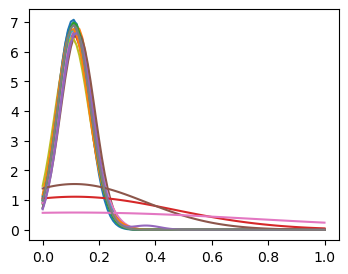

In [ ]:
# https://www.nature.com/articles/s41598-018-25999-0

# 15-seconds non-overlapping time windows
assumed_length = 360  # first condition
# window_time = 15  # time width of window
window_time = 20  # time width of window

va = feature_extract_method_2(df_ID_new , dynamic_feature='holdTime', assumed_length=assumed_length, window_time=window_time)

In [ ]:
va

array([1.36469890e-01, 5.00133506e-02, 1.39509793e-01, 2.33804120e-01,
       8.57285655e+00, 1.50883781e+01, 1.85257573e+00, 2.31663868e+00,
       2.78770593e+00, 1.54881843e+00, 4.76697714e+02])

## Read data - (2. dataset TAPPY)

In [ ]:
directory_path1 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Archived users/'
files_list1 = os.listdir(directory_path1)
data1 = pd.read_table(
    directory_path1 + files_list1[11], sep=': ', names=['Value'], engine='python')
data1

ParserError: Expected 1 fields in line 2, saw 2. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.

In [ ]:
directory_path1 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Archived users/'
files_list1 = os.listdir(directory_path1)

users = [el.split("_")[1].split(".")[0] for el in files_list1]
df_ID2 = pd.DataFrame(data=users, columns=['pID'])

directory_path2 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Tappy Data/'
files_list2 = os.listdir(directory_path2)

for i, el in enumerate(df_ID2['pID']):
    temp = [x for x in files_list2 if x.startswith(el)]
    if len(temp):
        df_ID2.loc[[i], 'files'] = pd.Series([temp], index=df_ID2.index[[i]])
        with open(directory_path1 + files_list1[i], 'r') as f:
            for line in f:
                if 'Parkinsons' in line:       
                    read_info = line.strip().split(": ")
                    df_ID2.loc[[i], 'Parkinsons'] = read_info[1]
                    
df_ID2.dropna(inplace=True)
df_ID2

,pID,files,Parkinsons
0,0EA27ICBLF,"[0EA27ICBLF_1607.txt, 0EA27ICBLF_1608.txt]",True
1,0QAZFRHQHW,"[0QAZFRHQHW_1609.txt, 0QAZFRHQHW_1610.txt]",False
3,1HOEBIGASW,[1HOEBIGASW_1702.txt],False
5,1XNJCXS3EY,[1XNJCXS3EY_1608.txt],False
6,2JTCBKUP8T,"[2JTCBKUP8T_1702.txt, 2JTCBKUP8T_1703.txt]",True
...,...,...,...
222,ZT9ASWFCFS,[ZT9ASWFCFS_1606.txt],True
223,ZWBPPNQCUX,"[ZWBPPNQCUX_1608.txt, ZWBPPNQCUX_1612.txt]",True
224,ZWHGXDUDLG,[ZWHGXDUDLG_1703.txt],True
225,ZY9CCHSPF2,"[ZY9CCHSPF2_1607.txt, ZY9CCHSPF2_1608.txt, ZY9...",True


Text(0.5, 0, 'Parkinson disease')

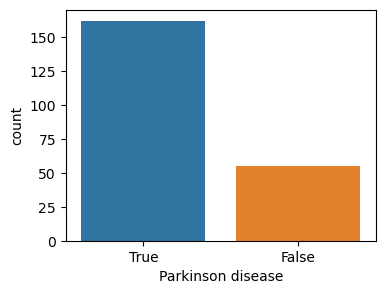

In [ ]:
plt.figure(figsize=[4,3])
sns.countplot(x = 'Parkinsons', data = df_ID2)
plt.xlabel('Parkinson disease')

In [ ]:
looking_str = files_list1[1].split("_")[1].split(".")[0]
looking_str

directory_path2 = 'D:/studia_mgrEIM/master_diploma/data/tappy-keystroke-data-1.0.0/Tappy Data/'
files_list2 = os.listdir(directory_path2)
results = [x for x in files_list2 if x.startswith(looking_str)]
results

['0QAZFRHQHW_1609.txt', '0QAZFRHQHW_1610.txt']

In [ ]:
data2 = pd.read_table(directory_path2 + results[0], index_col=False, names=[
                      'User', 'Date', 'Timestamp', 'Hand', 'holdTime', 'Direction', 'flightTime', 'latencyTime', ])
data2.drop(columns=['User'], inplace=True)
data2['holdTime']=data2['holdTime']/1000
data2['flightTime']=data2['flightTime']/1000
data2['latencyTime']=data2['latencyTime']/1000
data2

,Date,Timestamp,Hand,holdTime,Direction,flightTime,latencyTime
0,160916,19:20:43.891,L,0.0781,LL,0.3125,0.2578
1,160916,19:20:44.344,L,0.0781,LL,0.4531,0.3750
2,160916,19:20:44.742,L,0.0625,LL,0.4141,0.3359
3,160916,19:20:45.516,L,0.0938,LL,0.7422,0.6797
4,160916,19:20:46.047,R,0.1016,LR,0.5234,0.4297
...,...,...,...,...,...,...,...
819,160930,09:32:11.242,R,0.0781,RR,0.2344,0.1094
820,160930,09:32:13.555,R,0.1563,LR,0.5586,0.4844
821,160930,14:09:36.102,L,0.0781,LL,0.4766,0.3594
822,160930,21:51:49.695,L,0.0938,LL,0.4531,0.3516


In [74]:
grouped_data = data2.groupby('Date').agg(list)
grouped_data['Length'] = grouped_data['Timestamp'].apply(len) 
grouped_data

,Timestamp,Hand,holdTime,Direction,flightTime,latencyTime,Length
Date,,,,,,,
160916,"[19:20:43.891, 19:20:44.344, 19:20:44.742, 19:...","[L, L, L, L, R, R]","[0.07809999999999999, 0.07809999999999999, 0.0...","[LL, LL, LL, LL, LR, RR]","[0.3125, 0.4531, 0.4141, 0.7422000000000001, 0...","[0.25780000000000003, 0.375, 0.3359, 0.6797000...",6
160918,"[10:35:01.508, 10:35:01.930, 10:35:02.164, 10:...","[L, R, R, L, R, R, R, R, L, L, L, R, R, L, R, ...","[0.10940000000000001, 0.21480000000000002, 0.0...","[RL, LR, RR, RL, RR, RR, LR, RR, LL, LL, LL, L...","[0.2891, 0.31639999999999996, 0.38280000000000...","[0.1758, 0.207, 0.168, 0.3906, 0.2813, 0.07809...",80
160919,"[18:39:21.977, 18:39:22.477, 18:39:22.922, 21:...","[L, L, L, R, L, L, R, L, R, L, R, L, L, R]","[0.07809999999999999, 0.0703, 0.07809999999999...","[LL, LL, LL, RR, RL, LL, LR, RL, LR, RL, LR, R...","[0.4219, 0.5078, 0.4375, 0.4063, 0.30469999999...","[0.3438, 0.42969999999999997, 0.36719999999999...",14
160921,"[16:34:25.703, 16:34:27.164, 16:45:29.914, 16:...","[L, L, L, L, R, L, L, L]","[0.0938, 0.10940000000000001, 0.125, 0.1406, 0...","[LL, LL, RL, LL, LR, RL, LL, LL]","[0.4531, 0.5117, 0.3359, 0.3555, 0.49610000000...","[0.3438, 0.418, 0.2266, 0.21480000000000002, 0...",8
160922,"[08:40:36.512, 08:40:37.027, 08:40:37.402, 08:...","[L, L, L, R, L, L, L, R, R, R, L, L, L, R, R, ...","[0.07809999999999999, 0.07809999999999999, 0.0...","[LL, LL, LL, RR, SL, LL, LL, LR, RR, SR, RL, L...","[0.3594, 0.5156000000000001, 0.3906, 0.2031, 0...","[0.2813, 0.4375, 0.3125, 0.125, 0.2344, 0.1211...",559
160923,"[15:54:36.141, 15:54:36.688, 15:54:36.938, 15:...","[L, L, L, L, R, R, L, R, L, S, R, R, L, R, L, ...","[0.0938, 0.0938, 0.0938, 0.10940000000000001, ...","[LL, LL, LL, LL, LR, RR, RL, SR, RL, LS, RR, R...","[0.1875, 0.5468999999999999, 0.25, 0.7813, 0.5...","[0.0938, 0.4531, 0.15630000000000002, 0.6875, ...",51
160925,"[09:04:27.662, 09:04:29.318]","[L, L]","[0.1211, 0.1465]","[LL, LL]","[0.4043, 0.6347999999999999]","[0.3477, 0.5078]",2
160926,"[14:19:25.395, 14:19:26.031, 14:19:26.680, 14:...","[L, R, L, R, L, L, L, R, R, L, L, R, R]","[0.1055, 0.15230000000000002, 0.082, 0.1367, 0...","[RL, LR, RL, LR, LL, LL, LL, LR, RR, LL, LL, L...","[0.5468999999999999, 0.5898, 0.7188, 0.7109, 0...","[0.4141, 0.4844, 0.5664, 0.6289, 0.1875, 0.574...",13
160927,"[13:47:29.781, 13:47:31.344, 19:24:13.188, 19:...","[L, L, L, R, R, R, L, R, R, R, L, R, R, L, R, ...","[0.0938, 0.15630000000000002, 0.1641, 0.1172, ...","[LL, LL, RL, LR, RR, RR, RL, LR, RR, LR, RL, L...","[0.44139999999999996, 0.44139999999999996, 0.2...","[0.3281, 0.3281, 0.10940000000000001, 0.2734, ...",30


In [75]:
idx=grouped_data['Length'].idxmax() # jeśli jest odpowiednia liczba znakow
new_rec=data2[data2['Date']==idx]
print(new_rec)

       Date     Timestamp Hand  holdTime Direction  flightTime  latencyTime
108  160922  08:40:36.512    L    0.0781        LL      0.3594       0.2813
109  160922  08:40:37.027    L    0.0781        LL      0.5156       0.4375
110  160922  08:40:37.402    L    0.0625        LL      0.3906       0.3125
111  160922  08:40:57.775    R    0.1055        RR      0.2031       0.1250
112  160922  14:15:30.012    L    0.0938        SL      0.3828       0.2344
..      ...           ...  ...       ...       ...         ...          ...
662  160922  22:36:15.094    R    0.1094        LR      0.2188       0.0625
663  160922  22:36:16.766    R    0.0781        RR      0.1875       0.1250
664  160922  22:36:19.953    L    0.1406        RL      0.6094       0.5156
665  160922  22:36:20.312    R    0.0938        LR      0.4063       0.2656
666  160922  22:36:20.820    R    0.0781        RR      0.5234       0.4297

[559 rows x 7 columns]


In [76]:
# map()

# timestring = new_rec['Timestamp'].iloc[0]
# ts = datetime.strptime(timestring,'%H:%M:%S.%f')
# ts.hour
# ts.minute
# ts.second

new_rec['Hour'] = new_rec['Timestamp'].apply(lambda x: datetime.strptime(x,'%H:%M:%S.%f').hour)
grouped_data = new_rec.groupby('Hour').agg(list)
grouped_data['Length'] = grouped_data['Date'].apply(len) 
grouped_data


C:\Users\Hanna\AppData\Local\Temp\ipykernel_12936\2654907115.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rec['Hour'] = new_rec['Timestamp'].apply(lambda x: datetime.strptime(x,'%H:%M:%S.%f').hour)


,Date,Timestamp,Hand,holdTime,Direction,flightTime,latencyTime,Length
Hour,,,,,,,,
8,"[160922, 160922, 160922, 160922]","[08:40:36.512, 08:40:37.027, 08:40:37.402, 08:...","[L, L, L, R]","[0.07809999999999999, 0.07809999999999999, 0.0...","[LL, LL, LL, RR]","[0.3594, 0.5156000000000001, 0.3906, 0.2031]","[0.2813, 0.4375, 0.3125, 0.125]",4
14,"[160922, 160922, 160922, 160922, 160922, 16092...","[14:15:30.012, 14:15:30.230, 14:15:31.391, 14:...","[L, L, L, R, R, R, L, L, L, R, R, L, S, L, R, ...","[0.0938, 0.09770000000000001, 0.1016, 0.1016, ...","[SL, LL, LL, LR, RR, SR, RL, LL, LL, LR, RR, R...","[0.38280000000000003, 0.21480000000000002, 0.2...","[0.2344, 0.1211, 0.10940000000000001, 0.4219, ...",547
19,"[160922, 160922]","[19:50:28.297, 19:50:29.625]","[L, L]","[0.0938, 0.125]","[LL, LL]","[0.4688, 0.4531]","[0.3281, 0.3438]",2
22,"[160922, 160922, 160922, 160922, 160922, 160922]","[22:36:14.922, 22:36:15.094, 22:36:16.766, 22:...","[L, R, R, L, R, R]","[0.15630000000000002, 0.10940000000000001, 0.0...","[RL, LR, RR, RL, LR, RR]","[0.2031, 0.21880000000000002, 0.1875, 0.609399...","[0.0625, 0.0625, 0.125, 0.5156000000000001, 0....",6


In [106]:
idx=grouped_data['Length'].idxmax()
new_rec2=new_rec[new_rec['Hour']==idx]
new_rec2.drop('Hour', axis=1, inplace=True)
# print(new_rec2)
# new_rec2.iloc[30:50]
# 
# # b=np.array([0,1,3,5,10])
# b.cumsum()

new_rec2['Timestamp'] = new_rec2['Timestamp'].apply(lambda x: datetime.strptime(x,'%H:%M:%S.%f'))
var = (new_rec2['Timestamp'].iloc[1:] - new_rec2['Timestamp'].iloc[:-1] ).dt.seconds()*1000
print(var)

new_rec2['tdiff'] = np.nan
# new_rec2['tdiff'].iloc[0] = 0

# new_rec2['tdiff'].iloc[1:] = pd.Series(var)
new_rec2.tail()
# new_rec2['td'] =  new_rec2['td'].total_seconds()
# new_rec2['td'] =  int(round(new_rec2['Timestamp'].diff().total_seconds() / 60))

# td_mins = int(round(td.total_seconds() / 60))
# type(new_rec2['Timestamp'].iloc[3])

# pandas.Timedelta

112    NaN
113    0.0
114    0.0
115    0.0
116    0.0
      ... 
654    0.0
655    0.0
656    0.0
657    0.0
658    NaN
Name: Timestamp, Length: 547, dtype: float64


C:\Users\Hanna\AppData\Local\Temp\ipykernel_12936\587453442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rec2.drop('Hour', axis=1, inplace=True)
C:\Users\Hanna\AppData\Local\Temp\ipykernel_12936\587453442.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rec2['Timestamp'] = new_rec2['Timestamp'].apply(lambda x: datetime.strptime(x,'%H:%M:%S.%f'))
C:\Users\Hanna\AppData\Local\Temp\ipykernel_12936\587453442.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,Date,Timestamp,Hand,holdTime,Direction,flightTime,latencyTime,tdiff
654,160922,1900-01-01 14:27:19.980,R,0.0781,SR,0.6094,0.4688,NaN
655,160922,1900-01-01 14:27:20.246,L,0.0938,RL,0.2500,0.1719,NaN
656,160922,1900-01-01 14:27:20.652,L,0.0938,LL,0.4063,0.3125,NaN
657,160922,1900-01-01 14:27:26.520,L,0.1250,RL,0.2500,0.1406,NaN
658,160922,1900-01-01 14:27:26.926,R,0.1094,LR,0.4219,0.2969,NaN


In [72]:
# pd.Timestamp('00:00:00.000','%H:%M:%S.%f')
datetime.strptime('00:00:00.000','%H:%M:%S.%f')
pd.Timestamp(datetime.strptime('00:00:00.000','%H:%M:%S.%f'))

Timestamp('1900-01-01 00:00:00')